# Convocatoria 1 - Proyecto 1
---

## Realizado por: Williams Mérida Parard

## 0) Cargar una de las imágenes histológicas

In [1]:
# Importación de librerias
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.morphology import remove_small_objects, remove_small_holes, convex_hull_image
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes as bfh
import math
import pandas as pd

### Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.


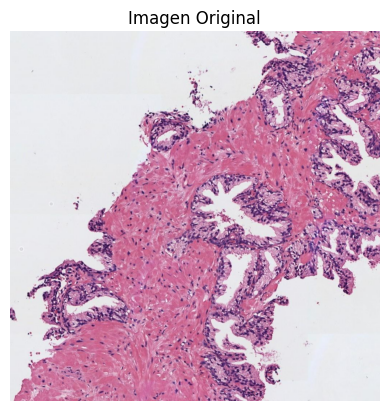

In [2]:
# Carga de la imagen
img = io.imread('./histo_1.jpg')
img_rgb = img.copy()
plt.imshow(img_rgb)
plt.title("Imagen Original")
plt.axis('off')
plt.show()

### Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]

In [3]:
img_norm = img_rgb.astype('uint8') / 255

### Visualizar la imagen

Dimensiones imagen sin normalizar:  (1024, 1024, 3) 
Valor máximo:  255 
Valor mínimo:  0 
Valor tipo:  uint8
Dimensiones imagen normalizada:  (1024, 1024, 3) 
Valor máximo:  1.0 
Valor mínimo:  0.0 
Valor tipo:  float64


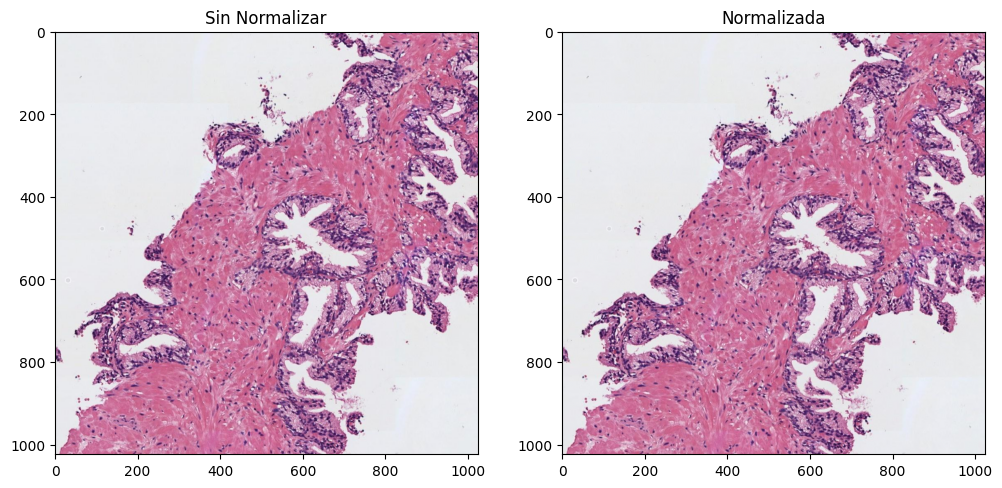

In [4]:
# Revisión de los datos y comparación de los datos.
print('Dimensiones imagen sin normalizar: ', np.shape(img),
      '\nValor máximo: ', np.max(img),
      '\nValor mínimo: ', np.min(img),
      '\nValor tipo: ', img.dtype)
print('Dimensiones imagen normalizada: ', np.shape(img_norm),
      '\nValor máximo: ', np.max(img_norm),
      '\nValor mínimo: ', np.min(img_norm),
      '\nValor tipo: ', img_norm.dtype)

# Comparación gráfica original vs normalizada
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(img), ax[0].set_title('Sin Normalizar')
ax[1].imshow(img_norm), ax[1].set_title('Normalizada')

plt.show()

---
## 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

### Extraer la componente magenta de la imagen (que corresponde a la región tisular)

In [5]:
# Creamos una función para la conversión de RGB a CMYK y separación de canales.
def convertir_a_CMYK(img_rgb_norm):
    with np.errstate(invalid='ignore', divide='ignore'):
        K = 1 - np.max(img_rgb_norm, axis=2)
        C = (1-img_rgb_norm[:,:,0]-K)/(1-K)
        M = (1-img_rgb_norm[:,:,1]-K)/(1-K)
        Y = (1-img_rgb_norm[:,:,2]-K)/(1-K)

    CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
    return CMYK

# Se ejecutan y separan los canales
img_cmyk = convertir_a_CMYK(img_norm)
C,M,Y,K = cv2.split(img_cmyk)

### Visualizar la imagen del canal magenta

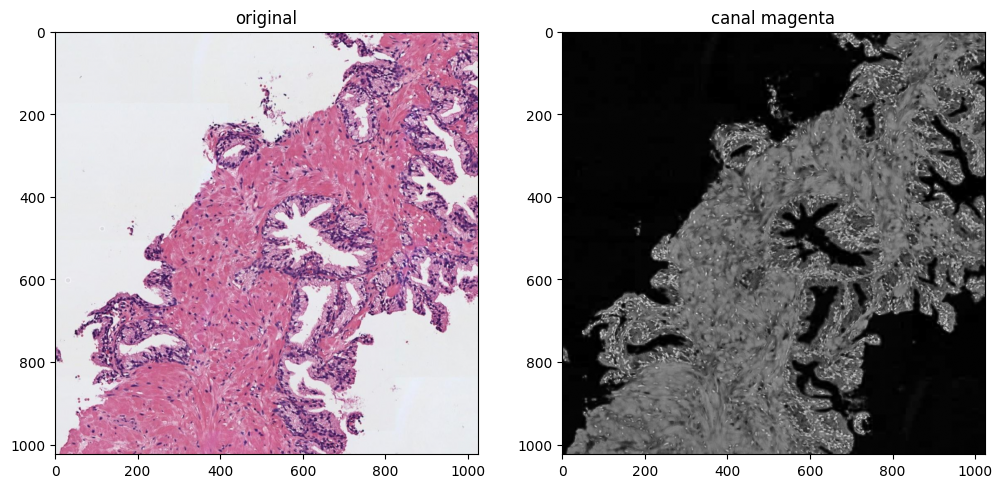

In [6]:
# Comparación visual orinal vs canal magenta
fig, ax = plt.subplots(1, 2, figsize = (12,6))
ax[0].imshow(img_norm, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(M.astype('uint8'), cmap='gray'), ax[1].set_title('canal magenta')

plt.show()

---
## 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

### Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
- Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

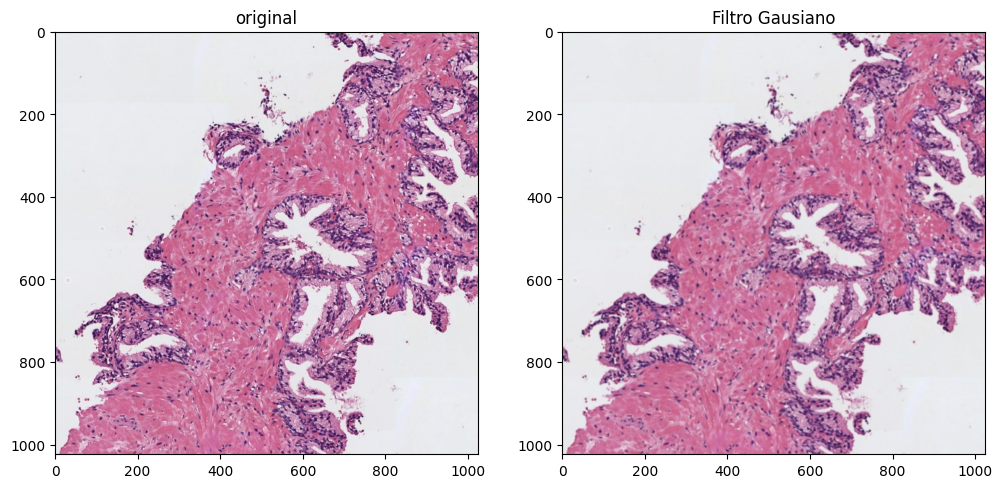

In [7]:
# Se aplica el filtro gausiano
img_gaussiana = cv2.GaussianBlur(img, (5,5),0)

# Comparación original vs filtro gausiano.
fig, ax = plt.subplots(1, 2, figsize = (12,6))
ax[0].imshow(img, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(img_gaussiana, cmap='gray'), ax[1].set_title('Filtro Gausiano')
plt.show()

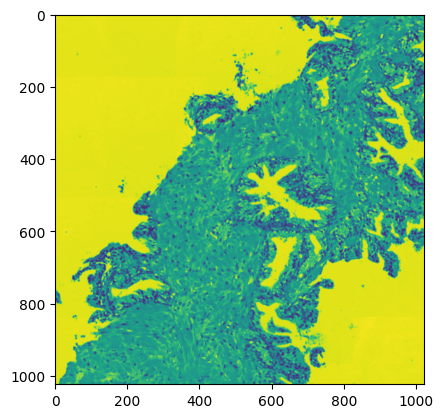

In [8]:
# Convertimos la imagen a gris para aplicar otsu
img_gris = cv2.cvtColor(img_gaussiana, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gris)

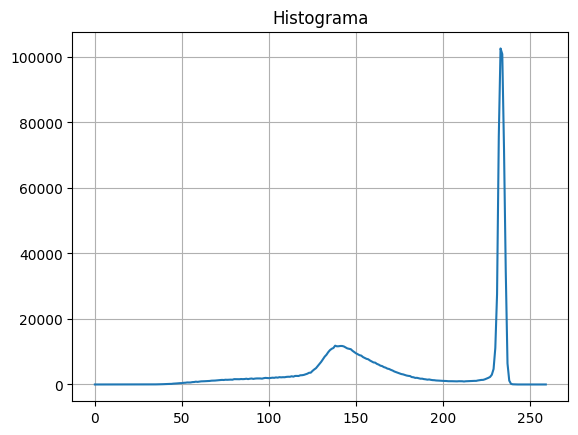

In [9]:
# Binarización automática Otsu y cálculo del histograma
t, mascara = cv2.threshold(img_gris ,0,1,cv2.THRESH_OTSU)

# Generación y visualización del histograma de intensidades
histograma = cv2.calcHist([img_gris], [0], None, [260], [0, 260]) 

plt.plot(histograma)
plt.grid()
plt.title('Histograma')
plt.show()


### Visualizar la máscara resultante


<Figure size 800x1000 with 0 Axes>

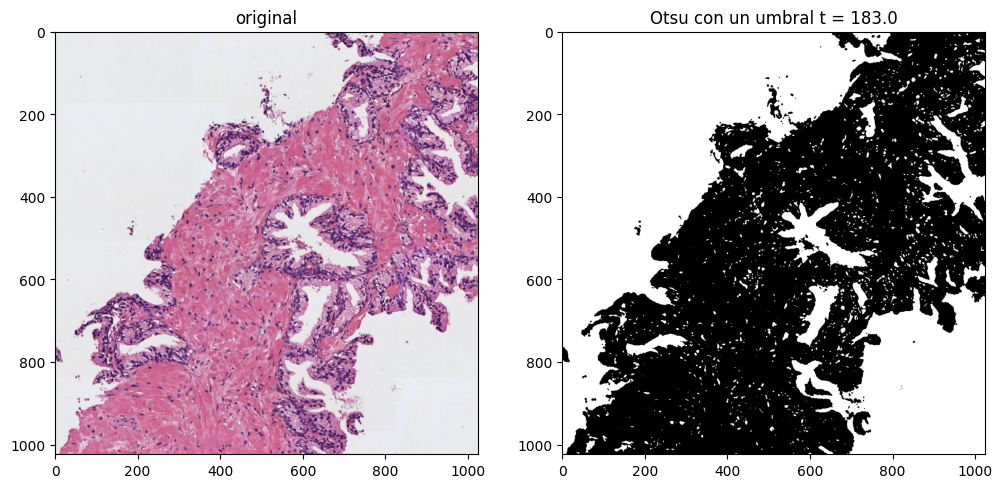

In [10]:
# Comparación visual original vs máscara Otsu
plt.figure(figsize= (8,10))
fig, ax = plt.subplots(1, 2, figsize = (12,6))
ax[0].imshow(img, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(mascara, cmap='gray'), ax[1].set_title(f'Otsu con un umbral t = {t}')
plt.show()

---
## 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

### Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
- Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects

In [11]:
# Procedemos a la eliminación de objetos pequeños y huecos en la máscara
matriz = mascara > 0
matriz_limpia = remove_small_objects(matriz, max_size=300)
img_limpia = remove_small_holes(matriz_limpia, max_size=300)

### Visualizar la máscara resultante

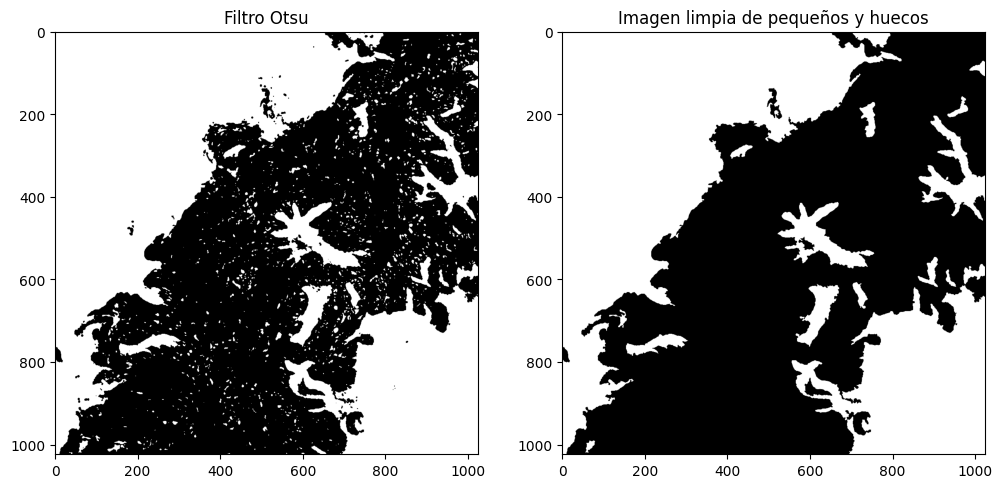

In [12]:
# Comparación visual antes y después de la limpieza
fig, ax = plt.subplots(1, 2, figsize = (12,6))
ax[0].imshow(mascara, cmap='gray'), ax[0].set_title('Filtro Otsu')
ax[1].imshow(img_limpia, cmap='gray'), ax[1].set_title('Imagen limpia de pequeños y huecos')
plt.show()

---
## 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

### Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos y el resto de la imagen negra. Pista: utilizar dos semillas. 
Nota: Se pueden fijar las semillas de manera manual, pero se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.


In [13]:
# Se eliminan los objetos del borde mediante.
mascara_01 = img_limpia.copy().astype(np.uint8)

# Definir una imagen negra de referencia
h, w = img_limpia.shape
mascara_02 = np.zeros((h + 2, w + 2), np.uint8)

# Relleno desde esquinas (superior izquierda e inferior derecha)
cv2.floodFill(mascara_01, mascara_02, (0,0), 0)
cv2.floodFill(mascara_01, mascara_02, (h-1,w-1), 0)      

(113273,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(1024, 1024), dtype=uint8),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 1],
        [1, 1, 1, ..., 0, 0, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], shape=(1026, 1026), dtype=uint8),
 (556, 615, 468, 409))

### Visualizar la máscara resultante. 

(<matplotlib.image.AxesImage at 0x20413e33250>,
 Text(0.5, 1.0, 'Procesado manteniendo lúmenes'))

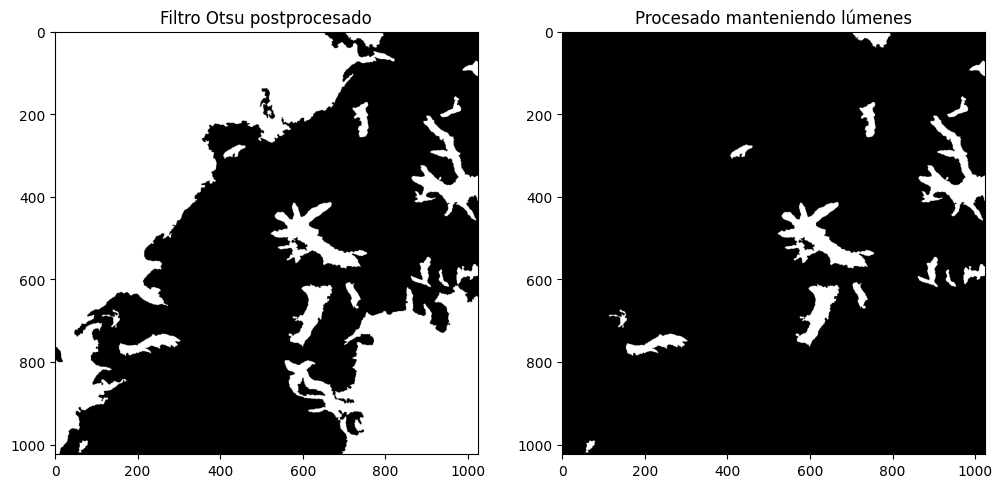

In [14]:
# Visualizamos la segmentación de lúmenes
fig, ax = plt.subplots(1, 2, figsize = (12,6))
ax[0].imshow(img_limpia, cmap='gray'), ax[0].set_title('Filtro Otsu postprocesado')
ax[1].imshow(mascara_01, cmap='gray'), ax[1].set_title('Procesado manteniendo lúmenes')

---
## 5) Rellenar los objetos de los lúmenes

### Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology

In [15]:
# Se rellenan los agujeros de los lúmenes segmentados
lumenes = mascara_01.copy()
lumenes_rellenos = bfh(lumenes)

### Visualizar la máscara resultante

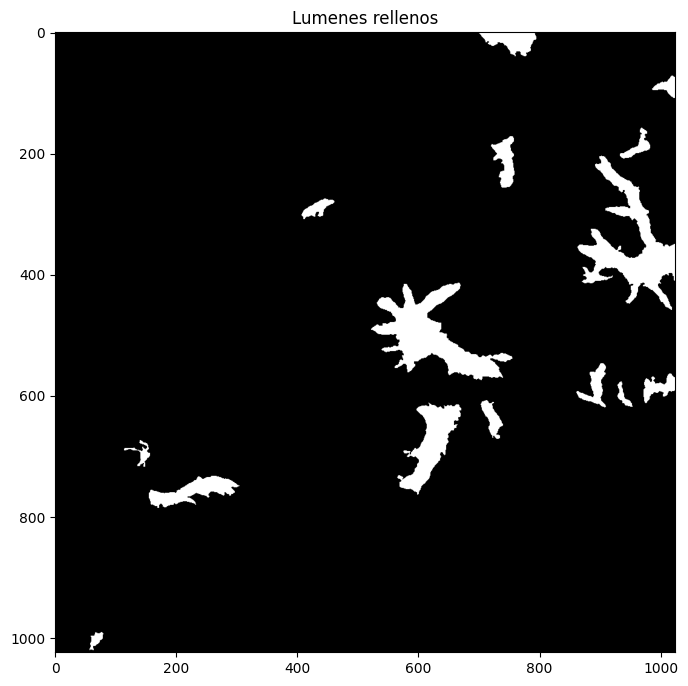

In [16]:
# Visualización final de los lúmenes rellenados
plt.figure(figsize= (8,10))
plt.imshow(lumenes_rellenos.astype('uint8'), cmap='gray')
plt.title('Lumenes rellenos')
plt.show()

---
## 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

### Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. 
Nota: Utilizar los flags necesarios para que los contornos en verde sean perfectamente visibles. 

Total objetos:  15
Valores de intensidad con potencial: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


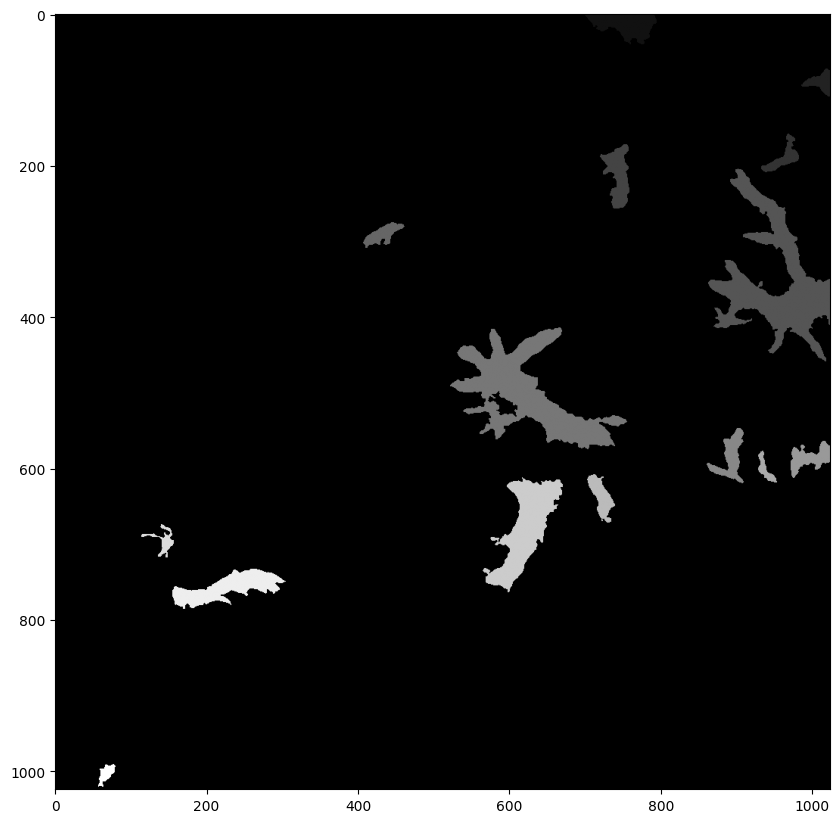

In [17]:
# Etiquetado de objetos conectados y conteo total
etiqueta, num = label(mascara_01, return_num=True)
print(f'Total objetos:  {num}')

# Análisis de las etiquetas únicas
v,c = np.unique(etiqueta, return_counts=True)
print(f'Valores de intensidad con potencial: {v}')

# Visualizamos las etiquetas
plt.figure(figsize= (10,12))
plt.imshow(etiqueta, cmap='gray')
plt.show()

In [18]:
# Se dibjuan los contornos sobre la imagen original
imagen = img.copy()
mascara_03 = mascara_01.copy()

# Iteración y dibujado de contornos
for i in range(1, num+1): 
    objeto = etiqueta == i
    objeto = objeto.astype('uint8')

    conts,_ = cv2.findContours(mascara_03, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen = cv2.drawContours(imagen, conts, -1, (0,255,0), 3)

### Visualizar la imagen superpuesta

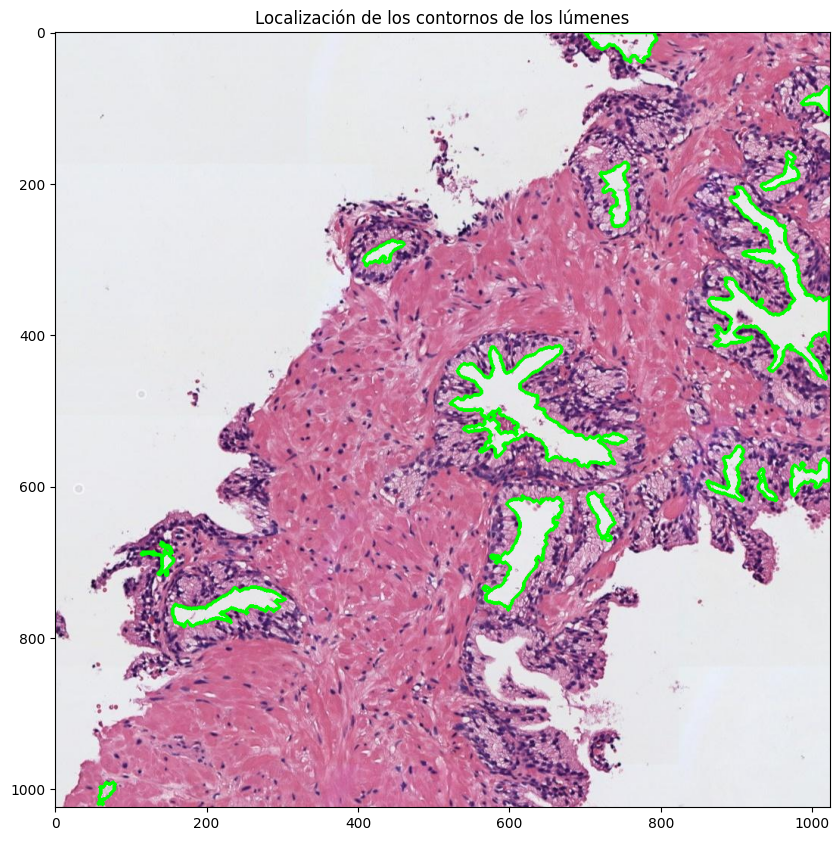

In [19]:
# Mostramos los contornos detectados
plt.figure(figsize= (10,12))
plt.imshow(imagen, cmap='gray')
plt.title('Localización de los contornos de los lúmenes')
plt.show()

---
## 7) Identificar y cropear el lumen más grande

### Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.

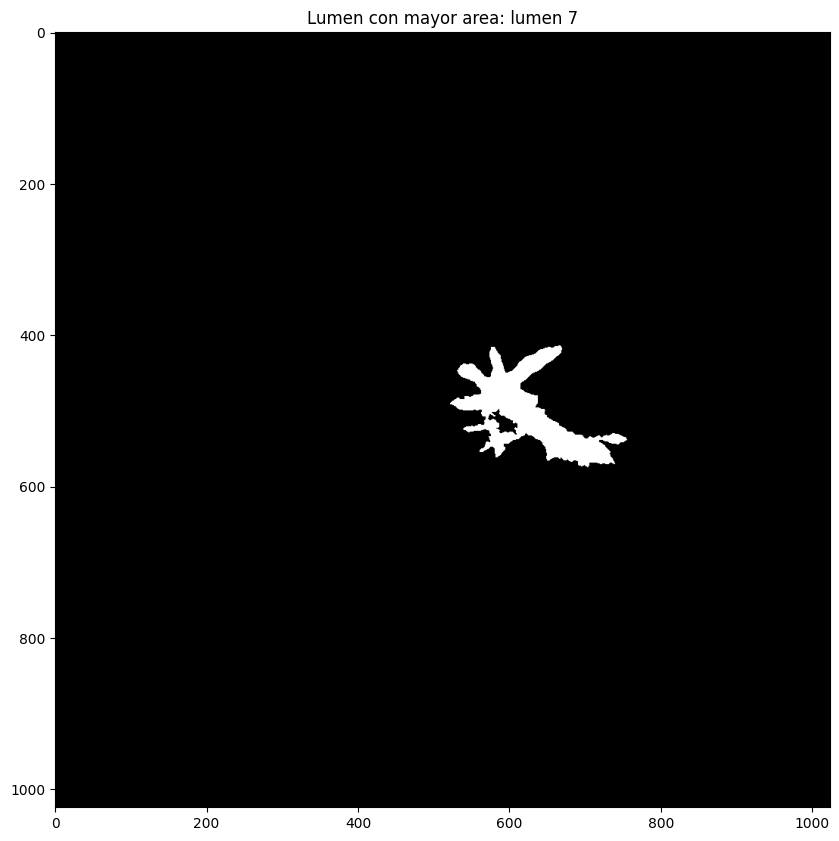

In [20]:
# Preparamos una lista vacía para guardar el tamaño de los lúmenes
areas = []

# Recorremos los objetos
for label in v[1:]:
    # Creamos un booleano para encontrar cuales son los píxeles con True
    objeto = etiqueta == label
    # Modificamos el booleano a formato numérico.
    objeto = objeto.astype('uint8')
    # Se calculan las propiedades geométricas
    propiedades = regionprops(objeto.astype(np.uint8))
    # Guardamos el objeto encontrado en nuestra lista.
    areas.append(np.round(propiedades[0].area, 4))

# Ahora buscamos el máximo de los valores guardados
lumen_mayor = max(areas)

for label in v[1:]:
    objeto = etiqueta == label
    objeto = objeto.astype('uint8')
    propiedades = regionprops(objeto.astype(np.uint8))

    # Es el área de este objeto es igual a la máxima encontrada?
    if np.round(propiedades[0].area, 4) == lumen_mayor:

        plt.figure(figsize= (10,12))
        plt.imshow(objeto, cmap='gray')
        plt.title(f'Lumen con mayor area: lumen {label}')
        plt.show()

### Visualizar el lumen cropeado.

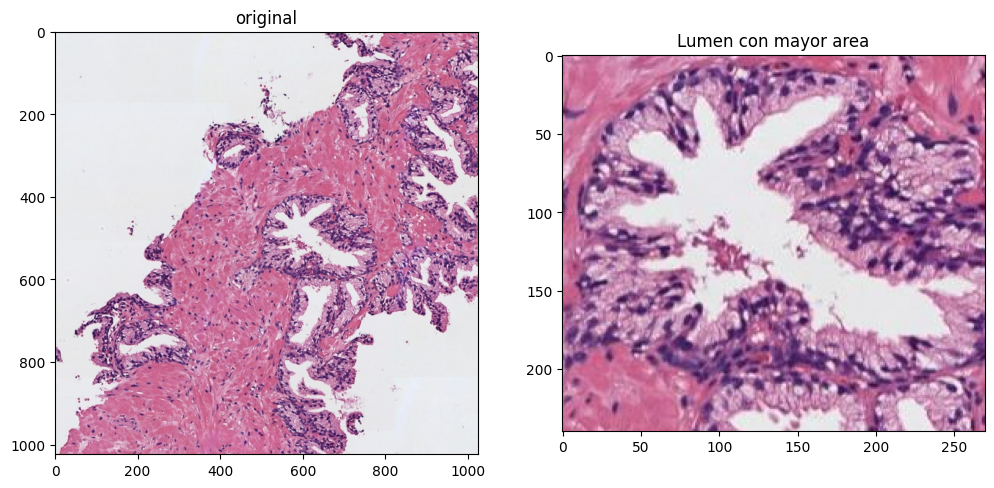

In [21]:
# Se recorta la imagen donde esta el lumen de mayor área 
lumen_cropeado = img[390:630, 490:760, :]

fig, ax = plt.subplots(1, 2, figsize = (12,6))
ax[0].imshow(img, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(lumen_cropeado, cmap='gray'), ax[1].set_title('Lumen con mayor area')
plt.show()

---
## 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

### Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
1) Área
2) Área de la bounding box
3) Área convexa
4) Exentricidad
5) Diámetro equivalente
6) Extensión
7) Diámetro Feret
8) Longitud del eje mayor
9) Longitud del eje menor
10) Orientación
11) Perímetro
12) Solidez
13) Compacidad

In [22]:
# Calculamos las propiedades de todos los lúmenes para encontrar el mayor
todas_las_propiedades = regionprops(etiqueta)

# Buscamos el objeto con el área máxima
lumen_mayor_props = max(todas_las_propiedades, key=lambda p: p.area)

# Obtenemos su máscara binaria para poder medir características como Feret
objeto_mayor = (etiqueta == lumen_mayor_props.label)

# Calculamos las características para el lumen recortado
p0 = lumen_mayor_props 

# Creamos un diccionario con las características
caracteristicas_lumen = {
    'Área': np.round(p0.area, 4),
    'Área Bounding Box': np.round(p0.area_bbox, 4),
    'Área Convexa': np.round(p0.area_convex, 4),
    'Excentricidad': np.round(p0.eccentricity, 4),
    'Diámetro Equivalente': np.round(p0.equivalent_diameter_area, 4),
    'Extensión': np.round(p0.extent, 4),
    'Diámetro Feret': np.round(p0.feret_diameter_max, 4),
    'Longitud Eje Mayor': np.round(p0.axis_major_length, 4),
    'Longitud Eje Menor': np.round(p0.axis_minor_length, 4),
    'Orientación': np.round(p0.orientation, 4),
    'Perímetro': np.round(p0.perimeter, 4),
    'Solidez': np.round(p0.solidity, 4),
    'Compacidad': np.round((4 * math.pi * p0.area) / (p0.perimeter**2 + 1e-8), 4)
}

# Se muestran los resultados
print("Características del Lumen de Mayor Área:")
for medida, valor in caracteristicas_lumen.items():
    print(f"{medida}: {valor}")

# Lo ponemos en un dataframe para una mejor visualización.
df_lumen = pd.DataFrame([caracteristicas_lumen]).T
df_lumen.columns = ['Valor']
display(df_lumen)

Características del Lumen de Mayor Área:
Área: 12818.0
Área Bounding Box: 37674.0
Área Convexa: 27461.0
Excentricidad: 0.8499
Diámetro Equivalente: 127.7513
Extensión: 0.3402
Diámetro Feret: 243.0823
Longitud Eje Mayor: 236.0455
Longitud Eje Menor: 124.366
Orientación: 0.9882
Perímetro: 1318.2012
Solidez: 0.4668
Compacidad: 0.0927


Valor
Área                  12818.0000
Área Bounding Box     37674.0000
Área Convexa          27461.0000
Excentricidad             0.8499
Diámetro Equivalente    127.7513
Extensión                 0.3402
Diámetro Feret          243.0823
Longitud Eje Mayor      236.0455
Longitud Eje Menor      124.3660
Orientación               0.9882
Perímetro              1318.2012
Solidez                   0.4668
Compacidad                0.0927